# Titanic 2: Decision Trees

**Dataset variables:**

*   survival -->	Whether a passenger survived or not
*   pclass -->	Ticket class (1 = 1st, 2 = 2nd, 3 = 3rd)
*   sex -->	Sex
*   Age -->	Age in years
*   sibsp -->	# of siblings / spouses aboard the Titanic
*   parch -->	# of parents / children aboard the Titanic
*   ticket -->	Ticket number
*   fare -->	Passenger fare
*   cabin -->	Cabin number
*   embarked -->	Port of Embarkation (C = Cherbourg, Q = Queenstown, S = Southampton)

## 1. Read the data

In [ ]:
import pandas as pd

url = "https://drive.google.com/file/d/1g3uhw_y3tboRm2eYDPfUzXXsw8IOYDCy/view?usp=sharing"
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]


data = pd.read_csv(path)
data.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


## 2. Define X and y

In [ ]:
X = data.drop(columns=["PassengerId", "Name", "Ticket"])
y = X.pop("Survived")

## 3. Data Splitting (Train - Test)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=31416)

## 5. Implement a Decision Tree

A Decision Tree is one of the simplest Machine Learning models. To implement it, we need to first:

- Import it from the appropriate submodule of Scikit-Learn.
- Initialize it.
- Fit it.

In [ ]:
# 1. import the model
from sklearn.tree import DecisionTreeClassifier

# 2. initialize the model (optional: give some parameters)
my_tree = DecisionTreeClassifier()

# 3. fit the model to the train data
my_tree.fit(X=X_train, y=y_train)

ValueError: ignored

We got an error: the model cannot deal with categorical features. We will soon learn to encode them as numbers, but our approach should always be to quickly complete the task  first, and iterate to improve it later. This is the reason why we will simply start by dropping the categorical features.

## 6. Select only numerical features


In [ ]:
# another option: X_num = X.drop(columns=["Sex", "Cabin", "Embarked"])
X_num = X.select_dtypes(include="number")

### 6.1. Train-test split

Since we created a new dataframe without the categorical features, we need to create our test and train sets again.

In [ ]:
X_num_train, X_num_test, y_train, y_test = train_test_split(X_num, y, test_size=0.2, random_state=123)

### 6.2. Implement a Decision Tree (numerical features)

In [ ]:
# 1. import the model
from sklearn.tree import DecisionTreeClassifier

# 2. initialize the model (optional: give some parameters)
my_tree = DecisionTreeClassifier()

# 3. fit the model to the train data
my_tree.fit(X=X_num_train, y=y_train)

ValueError: ignored

Another error: the model cannot deal with missing data. Let's fix it.

## 7. Dealing with missing data

We will use the `SimpleImputer()` with its default values. It will replace any missing value with the mean of the column it belongs to.

In [ ]:
# import
from sklearn.impute import SimpleImputer

# initialize
my_imputer = SimpleImputer()

# fit
my_imputer.fit(X_num_train)

# transform train 
X_num_imputed_train = my_imputer.transform(X_num_train)

### 7.2. Implement a Decision Tree (numerical features + missing values imputed)

In [ ]:
# 1. import the model
from sklearn.tree import DecisionTreeClassifier

# 2. initialize the model (optional: give some parameters)
my_tree = DecisionTreeClassifier()

# 3. fit the model to the train data
my_tree.fit(X = X_num_imputed_train, 
            y = y_train)

DecisionTreeClassifier()

### 7.3. Make predictions and check accuracy on the train set

In [ ]:
# make predictions
y_pred_tree_train = my_tree.predict(X_num_imputed_train)

In [ ]:
# Check accuracy on the train set
from sklearn.metrics import accuracy_score

accuracy_score(y_true = y_train,
               y_pred = y_pred_tree_train
              )

0.9564606741573034

The model seems to work REALLY well. Suspiciously well, even. Remember that the model has been trained using the train set and we have now checked its accuracy on the very same train set. The real evaluation will come from the test set.

## 8. Check accuracy for the test set

Is the model able to generalize? Is it able to make predictions on data it has not "seen" before?

### 8.1. Transform the test set

The test set already contains only numerical features, but we still need to impute the missing values with the "imputer" we already created and fitted on the train set.

Remember: transformers only have to be fitted to the train set. Then, they are used to transform both the train and the test set.

In [ ]:
# impute NaN's to test set
X_num_imputed_test = my_imputer.transform(X_num_test)

### 8.2. Make predictions on the test set

In [ ]:
y_pred_tree_test = my_tree.predict(X_num_imputed_test)

### 8.3. Check accuracy score on the test set

In [ ]:
accuracy_score(y_true = y_test,
               y_pred = y_pred_tree_test
              )

0.6703910614525139

This accuracy is even lower than some of our intuition-based models...

Our model has a **very high variance**: the difference between train and test set is huge. We can also say that our model suffers from **overfitting**: it has captured patterns in the training set that were not present in the testing set (they were mere "noise").

We will need to improve the model.

## 9. Plotting the Decision Tree

A Decision Tree is a succession of rules that split the dataset based on the variables that better predict the target. This tree, with its rules, can be visualized in a diagram:

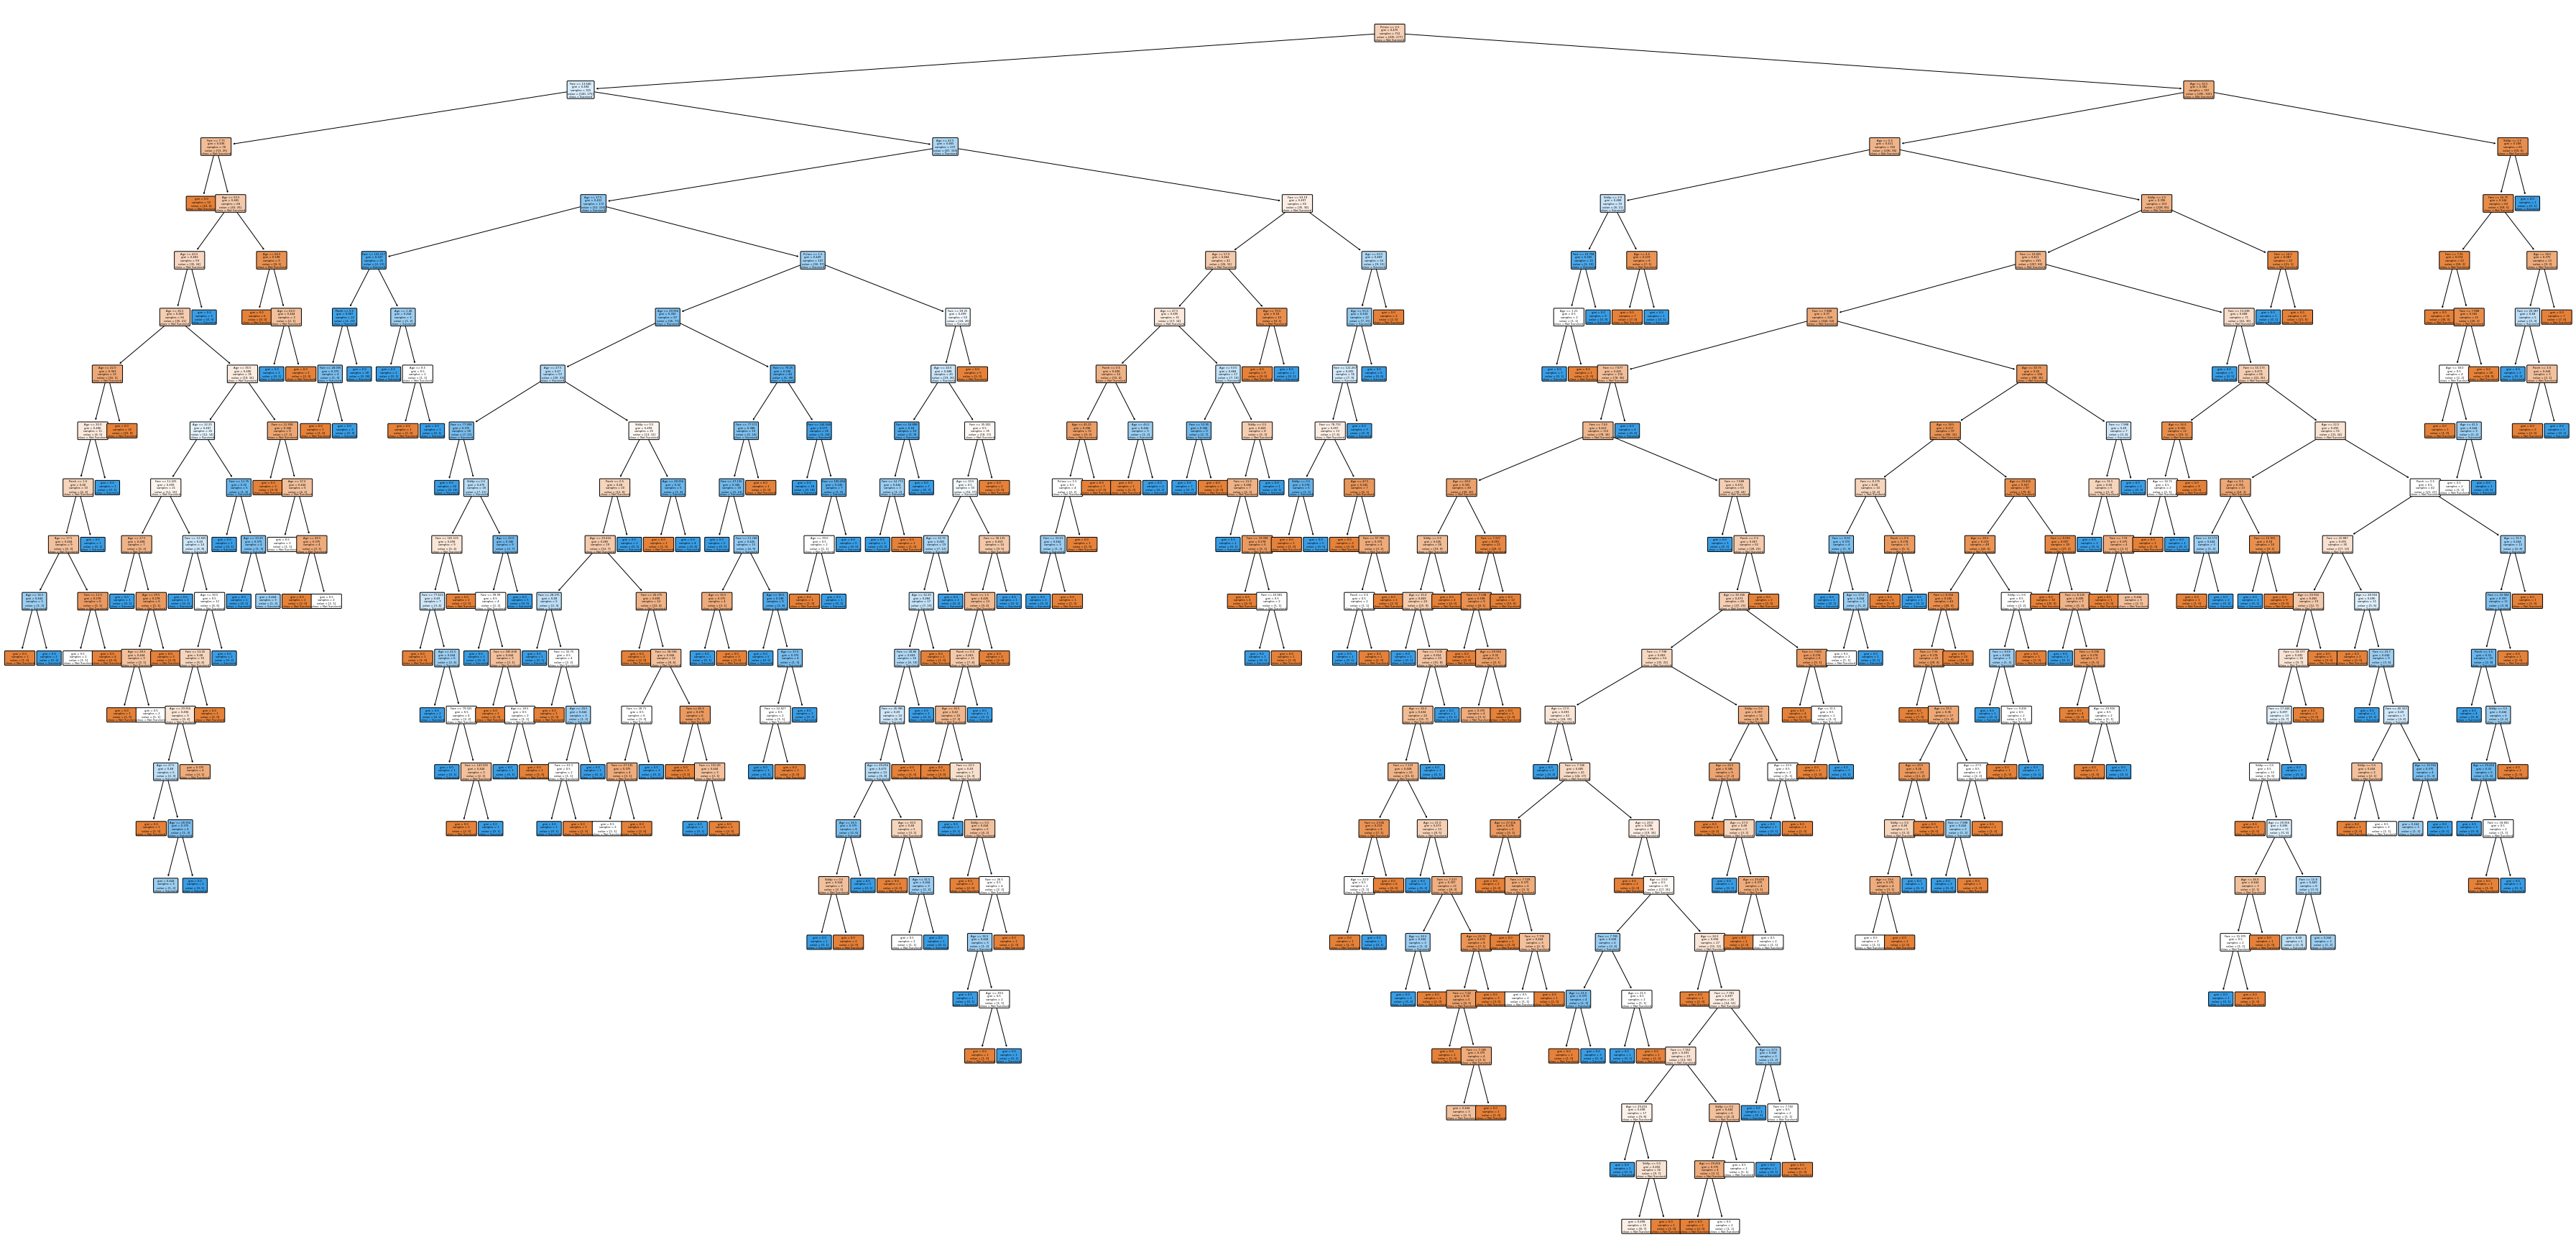

In [ ]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

plt.figure(figsize=(64, 32))

plot_tree(
     my_tree,
     filled=True, 
     rounded=True, 
     class_names=['Not Survived','Survived'], 
     feature_names=X_num.columns
     );

Our current tree is too big to distinguish what's going on. It has dozens, maybe hundreds of rules. In other words, our model is **very complex**, which is a common characteristic of models that suffer from overfitting.

To reduce the complexity (the size) of the tree and prevent overfitting, we can play with the hyperparameters of the tree. It's a process known as "pruning" the tree.

### **Exercise 1**: Pruning the tree

1. Tweak the parameters `max_depth` and `min_samples_leaf` of the decision tree, based on the Scikit-Learn documentation and the Statquest videos you watched following the Learning Platform.
2. Try to make the tree smaller.
3. Visualize again the tree.
4. Check the performance of your "small tree" on the train & test sets.

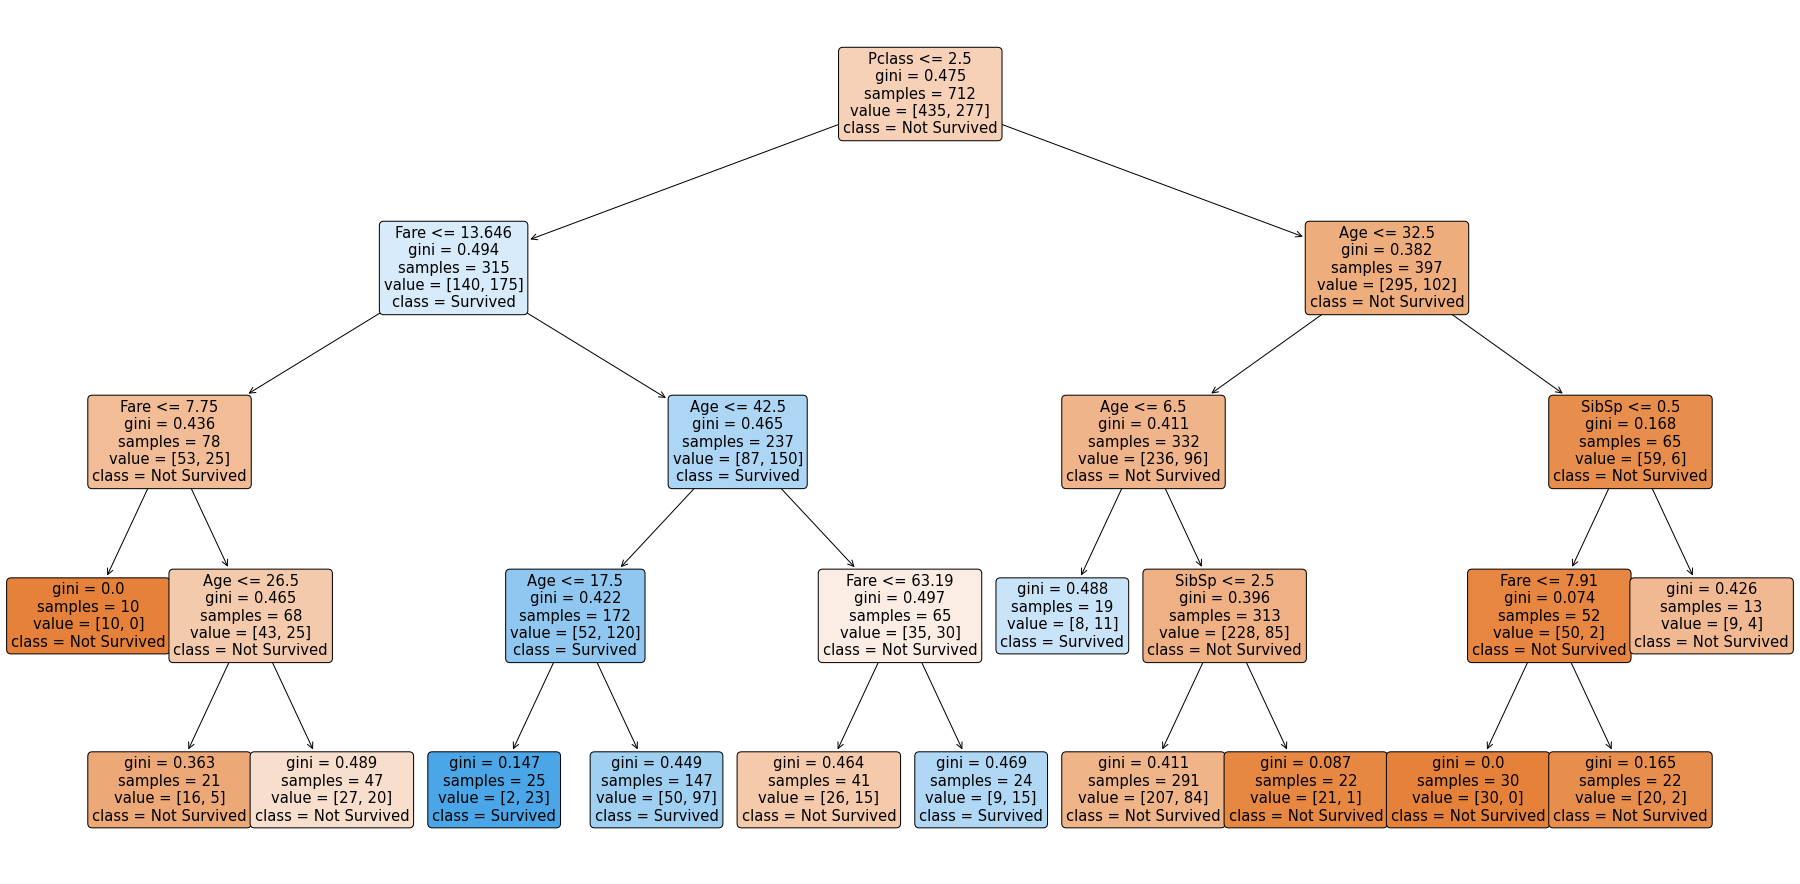

In [ ]:
# Solution:
# 2. initialize the model (optional: give some parameters)
my_tree = DecisionTreeClassifier(max_depth=4,
                                 min_samples_leaf=10
                                )

# 3. fit the model to the train data
my_tree.fit(X = X_num_imputed_train, 
            y = y_train)

plt.figure(figsize=(32, 16))
plot_tree(
    my_tree,
    filled=True, 
    rounded=True, 
    class_names=['Not Survived','Survived'], 
    feature_names=X_num.columns
    );

## **Your challenge**

In a new notebook, apply everything you have learned here to the Housing project, following the Learning platform.